# LID validation

Validation of LID is made against the experimental results obtained by the O. Medvedev et al. at Ioffe Institute. The results of validation were initially presented at OSSFE 2025 and they can be found in the [Git repository](https://github.com/KulaginVladimir/LID-validation). However, some experimental details we clarified since then, so minor updates were made in modeilling. The updated results are presented here with all scripts to reproduce them.

In [2]:
path = "/mnt/X/PhD_data/LID/"

## Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re

mpl_params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
            r"\usepackage{amsmath}",
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[russian]{babel}",
        ]
    ),
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.family": "Times New Roman",
    "font.size": 12,
    "legend.frameon": False,
}

plt.rcParams.update(mpl_params)
mm2inch = 1e-1 / 2.54

## Laser beam properties

The following script was used for visualisation: https://github.com/mickelsp/jessen-group/blob/master/Python%20Conversions/BeamGage_2DFitting.py

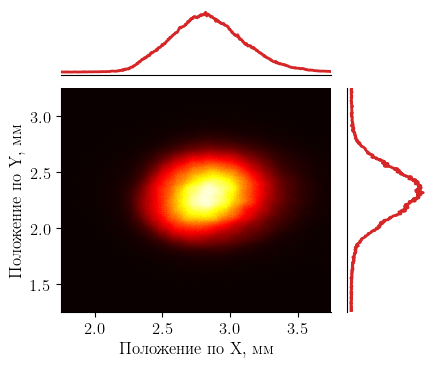

In [18]:
beamData = np.loadtxt(
    "./experimental_data/beam_profiles/SpatialProfile.csv",
    delimiter=";",
    usecols=range(1600),
)

beamData = np.flipud(
    beamData
)  # Reorder the rows of the array because Python defined the origin differently than the Beam Gage software
beamData = np.rot90(
    beamData, k=1
)  # Rotate the array by 90 degrees to make rows be the horizontal (x) data and columns the vertical (y) data
beamData = beamData.ravel()

pixelSizeCal = 4.4  # [microns/pixel] Size of each pixel
numPixelsX, numPixelsY = 1200, 1600  # [pixels] Number of pixels in x and y directions
positionX = (
    np.arange(0, numPixelsX) * pixelSizeCal
)  # [microns] Position in horizontal direction
positionY = (
    np.arange(0, numPixelsY) * pixelSizeCal
)  # [microns] Position in vertical direction
positionX, positionY = np.meshgrid(
    positionX, positionY
)  # [microns] Create a grid with same dimensions as x and y axes

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(120 * mm2inch, 100 * mm2inch))
gs = GridSpec(4, 4)

ax_hist = fig.add_subplot(gs[1:4, 0:3])
ax_line_y = fig.add_subplot(gs[0, 0:3])
ax_line_x = fig.add_subplot(gs[1:4, 3])

beamData = beamData.reshape(numPixelsY, numPixelsX)

ax_hist.pcolormesh(
    positionX / 1e3, positionY / 1e3, beamData, cmap="hot"
)  # Plot the raw data
ax_hist.set_xlabel("Положение по X, мм")
ax_hist.set_ylabel("Положение по Y, мм")
ax_hist.set_ylim(1.250, 3.250)
ax_hist.set_xlim(1.750, 3.750)
# ax_hist.set_xticks([1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75])

ax_line_y.plot(positionX[0, :] / 1e3, beamData[500, :], lw=2, color="tab:red")
ax_line_y.set_xlim(1.750, 3.750)
ax_line_y.tick_params(
    axis="both",
    which="both",
    bottom=False,
    labelbottom=False,
    left=False,
    labelleft=False,
)
ax_line_y.spines[["left"]].set_visible(False)

ax_line_x.plot(beamData[:, 750], positionY[:, 0] / 1e3, lw=2, color="tab:red")
ax_line_x.set_ylim(1.250, 3.250)
ax_line_x.tick_params(
    axis="both",
    which="both",
    bottom=False,
    labelbottom=False,
    left=False,
    labelleft=False,
)
ax_line_x.spines[["bottom"]].set_visible(False)

# plt.savefig('../../../../Thesis/images/laser_spatial_distr.png', dpi=1000, bbox_inches="tight", pad_inches=0.02)
plt.show()

The measured sparial distribution of laser intensity is close to the gaussian distribution. For both duration of the laser pulse, a single gaussian distribution was used with width of 1 mm.

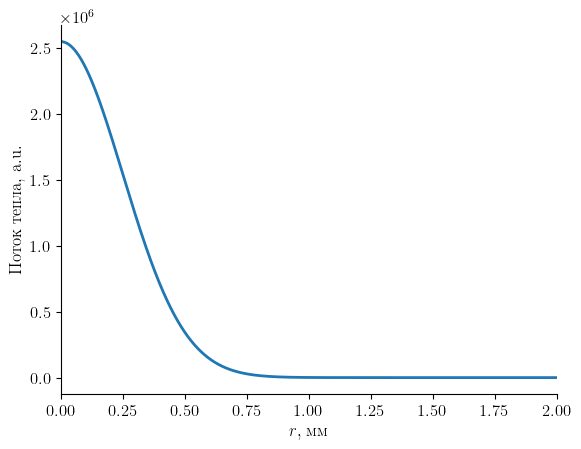

In [19]:
width = 1e-3
sigma_r = width / 4

profile = lambda r: 1 * np.exp(-(r**2) / 2 / sigma_r**2) / 2 / np.pi / sigma_r**2
r = np.linspace(0, 2e-3, num=10000)

plt.plot(r / 1e-3, profile(r), lw=2)

plt.xlabel(r"$r$, мм")
plt.ylabel("Поток тепла, a.u.")
plt.xlim(0, 2)
plt.show()

## LID experimental data

Experiments involved a series of laser irradiations of W films with varying beam energy. At each beam energy, multiple laser shots to the same area were performed. In the present work, only first pulse for each laser energy are used.

In [20]:
pd.options.mode.chained_assignment = None


def get_leak(leak_file):
    """
    Evaluates the QMS signal corresponding to the leak

    :param leak_file: name of a file containing the raw data
    :type leak_file: str
    :return: leak value
    :rtype: float
    """

    data = pd.read_csv(leak_file, skiprows=328, header=None, sep=",").dropna(axis=1)

    data[0] = pd.to_datetime(data[0])
    data[0] = (data[0] - data[0][0]).dt.total_seconds()

    mass3 = data[data[1] == 3.0].reset_index(drop=True).drop(columns=1)
    mass4 = data[data[1] == 4.0].reset_index(drop=True).drop(columns=1)
    mass3 = mass3.rename(columns={0: "Time, s", 2: f"Signal, A"})
    mass4 = mass4.rename(columns={0: "Time, s", 2: f"Signal, A"})
    leak = mass4["Signal, A"][mass4["Time, s"] > 80].mean()

    return leak


def get_first_pulse(data, leak):
    """
    Computes the calibrated QMS signal

    :param data: raw data
    :type data: pd.DataFrame
    :param leak: leak value
    :type leak: float
    :return: cutted data of the first pulse per masses 3 and 4, and the integral amount of desorbed D
    :rtype: list, float
    """

    period = 10
    k = 1.57005e14  # calibration factor

    total_fluence = 0
    max_t = data[1]["Time, s"][data[1]["Signal, A"] == max(data[1]["Signal, A"])].iloc[
        0
    ]

    first_pulse = []

    for i, data in enumerate(data):
        data = data.rolling(10).mean()

        data["Signal, A"] = (
            data["Signal, A"] - data["Signal, A"][data["Time, s"] <= 1].mean()
        )
        noise_max = data["Signal, A"][data["Time, s"] <= 2].max()

        cut_data = data[
            (data["Time, s"] <= max_t + period * 2 / 3) & (data["Time, s"] > max_t - 2)
        ]

        cut_data["Flow rate, D/s"] = cut_data["Signal, A"] * k / leak / 2 * (i + 1)

        first_pulse.append(cut_data)

        if noise_max * 5 >= cut_data["Signal, A"].max():
            total_fluence += 0  # if the signal below the noise, skip it
        else:

            left_tzero = cut_data["Time, s"][
                (cut_data["Time, s"] < max_t) & (cut_data["Signal, A"] <= 0)
            ].iloc[-1]

            try:
                right_tzero = cut_data["Time, s"][
                    (cut_data["Time, s"] > max_t) & (cut_data["Signal, A"] <= 0)
                ].iloc[0]
            except:
                right_tzero = cut_data["Time, s"].max()

            flow = cut_data["Flow rate, D/s"][
                (cut_data["Time, s"] >= left_tzero)
                & (cut_data["Time, s"] <= right_tzero)
            ]

            time = cut_data["Time, s"][
                (cut_data["Time, s"] >= left_tzero)
                & (cut_data["Time, s"] <= right_tzero)
            ]

            total_fluence += np.trapz(
                y=flow,
                x=time,
            )

    return first_pulse, total_fluence


def get_fluences(folder, name, leak):
    fluences = []
    raw_data = []
    calibrated_first_pulses = []

    for file in sorted(os.listdir(folder)):
        filename = os.fsdecode(file)
        if filename.endswith(".csv") and filename.startswith(name):
            data = pd.read_csv(
                folder + filename, skiprows=328, header=None, sep=","
            ).dropna(axis=1)

            data[0] = pd.to_datetime(data[0])
            data[0] = (data[0] - data[0][0]).dt.total_seconds()

            mass3 = data[data[1] == 3.0].reset_index(drop=True).drop(columns=1)
            mass4 = data[data[1] == 4.0].reset_index(drop=True).drop(columns=1)
            mass3 = mass3.rename(columns={0: "Time, s", 2: f"Signal, A"})
            mass4 = mass4.rename(columns={0: "Time, s", 2: f"Signal, A"})

            separated_data = [mass3, mass4]

            first_pulse, fluence = get_first_pulse(separated_data, leak)

            raw_data.append(separated_data)
            fluences.append(fluence)
            calibrated_first_pulses.append(first_pulse)

    return raw_data, calibrated_first_pulses, fluences


folders = [
    "./experimental_data/LID_data/220 mks/",
    "./experimental_data/LID_data/1 ms/",
]
names = ["50824", "60824"]
labels = ["220 us", "1 ms"]
laser_energies = [
    [0.054, 0.078, 0.124, 0.171, 0.216, 0.261, 0.306, 0.351],  # 250 us
    [0.066, 0.16, 0.255, 0.34951, 0.444, 0.53771, 0.636, 0.823, 1.003],  # 1 ms
]
raw_datas = []
first_pulses = []
fluences = []
for i, folder in enumerate(folders):

    leak = get_leak(folder + "leak.csv")
    raw_data, first_pulse, fluence_series = get_fluences(folder, names[i], leak)

    raw_datas.append(raw_data)
    first_pulses.append(first_pulse)
    fluences.append(fluence_series)

    export = np.column_stack([laser_energies[i], fluence_series])

    np.savetxt(
        "./experimental_data/" + labels[i] + ".csv",
        export,
        header="Energy(J),Fluence(-)",
        delimiter=",",
    )

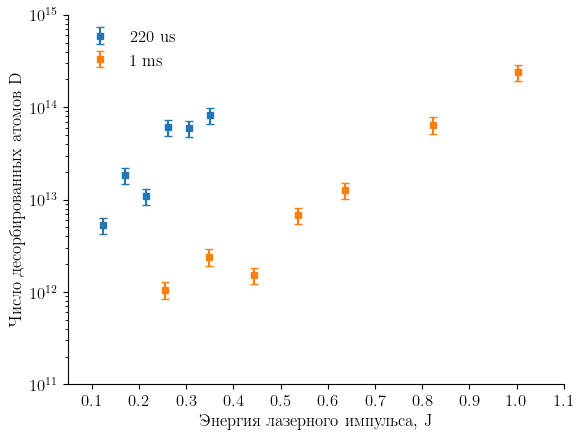

In [21]:
for i, fluence_dat in enumerate(fluences):
    plt.errorbar(
        laser_energies[i],
        np.array(fluence_dat),
        yerr=np.array(fluence_dat) * 0.2,
        fmt="s",
        markersize=5,
        capsize=3,
        label=labels[i],
    )


plt.legend(frameon=False)
plt.yscale("log")
plt.xlim(0.05, 1.05)
plt.ylim(1e11, 1e15)
plt.xticks([i / 10 for i in range(1, 12)])
plt.xlabel("Энергия лазерного импульса, J")
plt.ylabel("Число десорбированных атомов D")
plt.show()

## Comparison between modelling and experiments

In [5]:
def get_data_2D(folder, duration, alpha):
    data = []
    for filename in os.listdir(folder):
        if (
            filename.startswith("results")
            and (duration in filename)
            and filename.endswith(f"_{alpha:.2f}")
        ):

            results = np.loadtxt(
                folder + filename + "/derived_quantities.csv", skiprows=1, delimiter=","
            )

            t = results[:, 0]
            flux = -results[:, 1]
            desorbed = np.trapz(flux, x=t)

            match_number = re.compile("-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?")
            floats = [float(x) for x in re.findall(match_number, filename)]

            E = float(floats[-2])
            data.append([E, desorbed])

    data = np.array(data)
    return data[data[:, 0].argsort()]

In [4]:
exp_data_220us = np.loadtxt(path+"LID_validation/experimental_data/220 us.csv", skiprows=1, delimiter=",")
exp_data_1ms = np.loadtxt(path+"LID_validation/experimental_data/1 ms.csv", skiprows=1, delimiter=",")

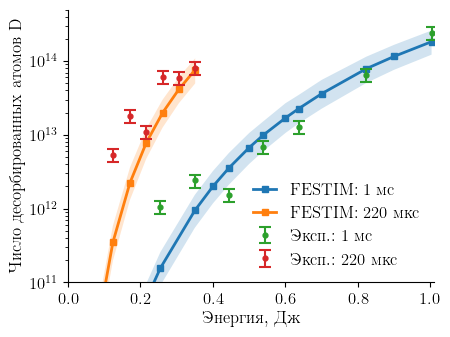

In [6]:
alphas = [0.5, 0.55, 0.6]

plt.figure(figsize=(120 * mm2inch, 90 * mm2inch))

plt.errorbar(
    exp_data_1ms[:, 0],
    exp_data_1ms[:, 1],
    yerr=exp_data_1ms[:, 1] * 0.20,
    fmt="o",
    markersize=3.5,
    capsize=4.5,
    label="Эксп.: 1 мс",
    color="tab:green",
    capthick=1.5,
    lw=1.5,
    zorder=4,
)

plt.errorbar(
    exp_data_220us[:, 0],
    exp_data_220us[:, 1],
    yerr=exp_data_220us[:, 1] * 0.20,
    fmt="o",
    markersize=3.5,
    capsize=4.5,
    label="Эксп.: 220 мкс",
    color="tab:red",
    capthick=1.5,
    lw=1.5,
    zorder=4,
)

festim_2D_1ms = []
festim_2D_220us = []
for alpha in alphas:
    festim_2D_1ms.append(get_data_2D(path+"LID_validation/out_data/", "1ms", alpha))
    festim_2D_220us.append(get_data_2D(path+"LID_validation/out_data/", "250us", alpha))

plt.plot(
    festim_2D_1ms[1][:, 0],
    festim_2D_1ms[1][:, 1],
    marker="s",
    ms=4,
    lw=2,
    zorder=3,
    label=r"FESTIM: 1 мс",
)

plt.fill_between(
    festim_2D_1ms[0][:, 0],
    festim_2D_1ms[0][:, 1],
    festim_2D_1ms[2][:, 1],
    alpha=0.2,
    lw=0,
)

plt.plot(
    festim_2D_220us[1][:, 0],
    festim_2D_220us[1][:, 1],
    marker="s",
    ms=4,
    lw=2,
    zorder=3,
    label=r"FESTIM: 220 мкс",
)

plt.fill_between(
    festim_2D_220us[0][:, 0],
    festim_2D_220us[0][:, 1],
    festim_2D_220us[2][:, 1],
    alpha=0.2,
    lw=0,
)

plt.yscale("log")
plt.ylim(1e11, 5e14)
plt.xlim(0.0, 1.01)
plt.ylabel("Число десорбированных атомов D")
plt.xlabel("Энергия, Дж")
plt.legend(handlelength=1.4)

plt.savefig(
    "../../../Thesis/images/LID_Comparison.pdf",
    bbox_inches="tight",
    pad_inches=0.01,
)
plt.show()

## Temperature and retention profiles

In [7]:
from dolfin import *
import fenics as f
import matplotlib.tri as tri


def read_field_xdmf(field_folder, field, mesh_folder):
    mesh = Mesh()
    with XDMFFile(MPI.comm_world, mesh_folder + "mesh.xdmf") as infile:
        infile.read(mesh)

    V = FunctionSpace(mesh, "CG", 2)
    field_func = f.Function(V)
    f.XDMFFile(field_folder + field + ".xdmf").read_checkpoint(
        field_func, "retention", -1
    )

    n = mesh.num_vertices()
    d = mesh.geometry().dim()

    # Create the triangulation
    mesh_coordinates = mesh.coordinates().reshape((n, d))
    triangles = np.asarray([cell.entities(0) for cell in cells(mesh)])
    triangulation = tri.Triangulation(
        mesh_coordinates[:, 0] * 1e3, mesh_coordinates[:, 1] * 1e6 - 6e3, triangles
    )

    if field == "retention":
        z = np.asarray(
            [
                (
                    field_func(point)
                    if not (
                        point[0] * 1e3 > 0.3
                        and point[1] * 1e6 < 0.1 + 6e3
                        and point[1] * 1e6 > -0.05 + 6e3
                        and float(field_func(point)) < 4.6e27
                    )
                    else 4.66e27
                )
                for point in mesh_coordinates
            ]
        )
    else:
        z = np.asarray([field_func(point) for point in mesh_coordinates])

    return triangulation, z

In [11]:
mesh, retention_1ms = read_field_xdmf(
    path+"LID_validation/out_data/results_1ms_1.003J_0.55/", "retention", path+"LID_validation/mesh_LID2D/"
)
mesh, retention_220us = read_field_xdmf(
    path+"LID_validation/out_data/results_250us_0.351J_0.55/", "retention", path+"LID_validation/mesh_LID2D/"
)
mesh_T, T_1ms = read_field_xdmf(path+"LID_validation/out_data/T_1ms/", "T_1ms", path+"LID_validation/mesh_T2D/")
mesh_T, T_220us = read_field_xdmf(
    path+"LID_validation/out_data/T_250us/", "T_250us", path+"LID_validation/mesh_T2D/"
)

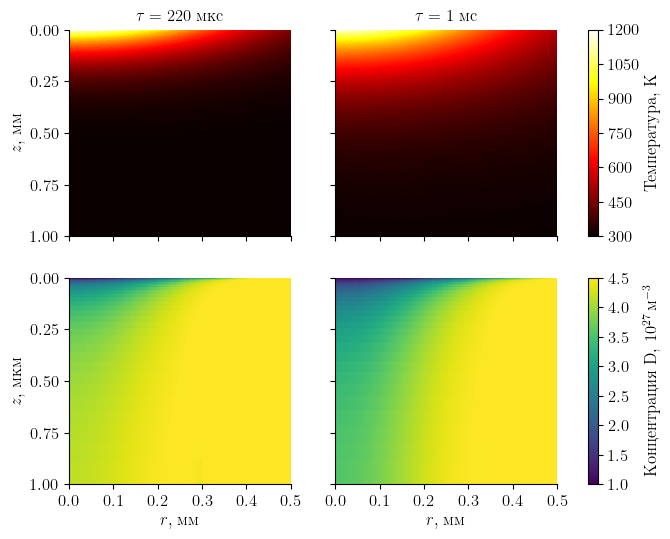

In [12]:
retention_1ms[np.where(retention_1ms < 0)] = 0
retention_220us[np.where(retention_220us < 0)] = 0

fig, axs = plt.subplots(
    2, 2, figsize=(200 * mm2inch, 150 * mm2inch), sharex=True, sharey="row"
)

pcf_T = axs[0, 0].tripcolor(
    mesh_T, T_220us, vmin=300, vmax=1200, cmap="hot", shading="gouraud"
)
axs[0, 1].tripcolor(mesh_T, T_1ms, vmin=300, vmax=1200, cmap="hot")

fig.colorbar(
    pcf_T,
    ax=axs[0, :],
    orientation="vertical",
    label="Температура, К",
    ticks=[i for i in range(300, 1350, 150)],
)

pcf_r = axs[1, 0].tripcolor(
    mesh, retention_220us / 1e27, vmin=1, vmax=4.5, shading="gouraud"
)
axs[1, 1].tripcolor(mesh, retention_1ms / 1e27, vmin=1, vmax=4.5, shading="gouraud")

cb = fig.colorbar(
    pcf_r,
    ax=axs[1, :],
    orientation="vertical",
    ticks=[1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5],
)
cb.set_label(r"Концентрация D, $\SI{e27}{\text{м}^{-3}}$", labelpad=11.3)

axs[0, 0].set_ylim(1 - 1e3, 1)
axs[0, 0].set_yticks([-1000, -750, -500, -250, 0])
axs[0, 0].set_yticklabels(["1.00", "0.75", "0.50", "0.25", "0.00"])
axs[0, 0].set_ylabel(r"$z$, мм")
axs[1, 0].set_ylabel(r"$z$, мкм")

axs[1, 0].set_yticks([0, 0.25, 0.5, 0.75, 1.0])
axs[1, 0].set_yticklabels(["1.00", "0.75", "0.50", "0.25", "0.00"])

axs[1, 0].set_xlabel(r"$r$, мм")
axs[1, 1].set_xlabel(r"$r$, мм")
axs[1, 0].set_ylim(0.0, 1.0)
axs[1, 0].set_xlim(0.0, 0.5)
axs[0, 1].set_title(r"$\tau=1$ мс", fontsize=12)
axs[0, 0].set_title(r"$\tau=220$ мкс", fontsize=12)
axs[1, 0].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

fig.align_ylabels()
plt.savefig(
    "../../../Thesis/images/LID_2D.png", bbox_inches="tight", pad_inches=0.01, dpi=600
)
plt.show()